In [1]:
NOTEBOOK_NAME = "e010_retrieve_same_lrg_cd"

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [3]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [4]:
# train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [5]:
train = pd.read_pickle(
    f"../saved_data/e010_make_train_retrieve_sale_lrg_cd/e010_make_train_retrieve_same_lrg_cd_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e010_make_train_retrieve_sale_lrg_cd/e010_make_train_retrieve_same_lrg_cd_merged_test.pkl"
)

In [6]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [7]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [8]:
# # ひとつ前のlogのyad_idの値を取得
# train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
# test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

# 正解のyadoと1つ前のyadoの情報の追加

In [9]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# train = pd.merge(
#     train,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

In [10]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# test = pd.merge(
#     test,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

# データ型の変更

In [11]:
# categorical_colの定義
base_categorical_cols = [
    # "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "lrg_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
# previous_1_yado_categorical_cols = [
#     f"previous_1_{col}" for col in base_categorical_cols
# ]

# categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols
categorical_cols = now_yado_categorical_cols

In [12]:
# categorical_cols.remove("now_yad_no")
# categorical_cols.remove("previous_1_yad_no")

# # leak的な何かしらが起きているので、今は使わない
# # TODO: 予測するyad_noは重要な情報だと思うため入れ方を考える

In [13]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [14]:
train

,session_id,yad_no,reserve,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd
0,000007603d533d30453cc45d0f3d119f,538,0,538,0,52.0,1.0,0,1.0,NaN,NaN,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
1,000007603d533d30453cc45d0f3d119f,1648,0,1648,0,180.0,1.0,0,1.0,NaN,NaN,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
2,000007603d533d30453cc45d0f3d119f,2134,0,2134,0,18.0,1.0,1,NaN,1.0,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
3,000007603d533d30453cc45d0f3d119f,2395,0,2395,0,113.0,1.0,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
4,000007603d533d30453cc45d0f3d119f,2528,0,2528,0,10.0,1.0,1,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454129,fffffa7baf370083ebcdd98f26a7e31a,9545,0,9545,0,163.0,1.0,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a
3454130,fffffa7baf370083ebcdd98f26a7e31a,10211,0,10211,0,128.0,1.0,0,NaN,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a
3454131,fffffa7baf370083ebcdd98f26a7e31a,11822,0,11822,0,161.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c
3454132,fffffa7baf370083ebcdd98f26a7e31a,12154,0,12154,0,70.0,NaN,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c


In [15]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

# skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# for fold, (_, v_idx) in enumerate(
#     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# ):
#     train.loc[v_idx, "fold"] = fold

sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
for fold, (_, v_idx) in enumerate(
    sgkf.split(
        X=train,
        y=train["reserve"],
        groups=train["session_id"],
    )
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [16]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.916451
      1          0.083549
1     0          0.916407
      1          0.083593
2     0          0.916420
      1          0.083580
3     0          0.916418
      1          0.083582
4     0          0.916402
      1          0.083598
Name: proportion, dtype: float64

# LightGBM

In [17]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

# numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col
numeric_cols = now_yado_numeric_col

In [18]:
use_col = numeric_cols + categorical_cols
len(use_col)

9

In [19]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": 3,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.3,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [20]:
# params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します.
#     "objective": "binary",
#     # 木の最大数
#     "n_estimators": 10000,
#     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     # 今回設定している 0.3 は比較的大きめの設定です
#     "learning_rate": 0.3,
#     # 特徴重要度計算のロジック(後述)
#     "importance_type": "gain",
#     "random_state": 510,
# }

In [21]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [34]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=3000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.269948	valid_1's binary_logloss: 0.270432
[200]	training's binary_logloss: 0.269308	valid_1's binary_logloss: 0.26989
[300]	training's binary_logloss: 0.268847	valid_1's binary_logloss: 0.269486
[400]	training's binary_logloss: 0.268548	valid_1's binary_logloss: 0.269265
[500]	training's binary_logloss: 0.268256	valid_1's binary_logloss: 0.269021
[600]	training's binary_logloss: 0.267992	valid_1's binary_logloss: 0.268834
[700]	training's binary_logloss: 0.267697	valid_1's binary_logloss: 0.268602
[800]	training's binary_logloss: 0.267439	valid_1's binary_logloss: 0.268402
[900]	training's binary_logloss: 0.267226	valid_1's binary_logloss: 0.268231
[1000]	training's binary_logloss: 0.267026	valid_1's binary_logloss: 0.268087
[1100]	training's binary_logloss: 0.266865	valid_1's binary_logloss: 0.267999
[1200]	training's binary_logloss: 0.266702	valid_1's binary_logloss: 0.267857

In [35]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

In [36]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "rb") as f:
    models = pickle.load(f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "rb") as f:
    oof = pickle.load(f)

In [38]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.7027669648888641

In [39]:
oof = np.zeros((len(train)))
oof[valid_idx] = y_valid_pred

In [40]:
train.shape

(3454134, 17)

In [41]:
# TODO: fold0のみだとスコアが小さく出てしまう問題を解決する
# map@10を計算
def create_top_10_yad_predict(oof: pd.DataFrame, train: pd.DataFrame) -> pd.DataFrame:
    _df = pd.concat(
        [train[["session_id", "yad_no"]], pd.Series(oof, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    out_df = out_df.fillna("0").astype(int)

    return out_df


oof_pred_yad_df = create_top_10_yad_predict(oof=oof[oof != 0], train=train[oof != 0])

oof_pred_yad_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
0000d4835cf113316fe447e2f80ba1c8,4863,7497,11624,9863,7257,4355,11724,5238,5693,8750
00011afe25c343301ee961b3b0ce2e4d,12929,12598,4203,10798,6868,5248,12981,12544,4732,4823
00026fd325b5d65d18e6de78ea2a3751,2813,12746,7591,8096,8822,2800,4191,13484,6877,6585
00039fce79dd894552382ea879027b6e,7394,10429,12147,5161,10225,12053,9662,8513,7114,10919
0004de948f2572426f6a481e15a5d80b,7429,4287,3228,6961,11234,4103,8079,2032,9917,11096
...,...,...,...,...,...,...,...,...,...,...
fffb7f81d4d63c0a2833fa6e52d045ed,91,1036,2214,2715,3535,6036,7071,8220,11462,11924
fffc996274862c136b754a5d591a3bb3,1058,2272,3158,5172,8830,10012,10022,10846,11575,12400
fffd8c4fa7b5be31f0bec4dee4ac6dc8,2487,5209,5704,6561,8414,10538,10918,11806,12036,13423


,session_id,yad_no
2,0000d4835cf113316fe447e2f80ba1c8,4863
5,00011afe25c343301ee961b3b0ce2e4d,4823
11,00026fd325b5d65d18e6de78ea2a3751,756
18,00039fce79dd894552382ea879027b6e,7394
23,0004de948f2572426f6a481e15a5d80b,11234
...,...,...
288674,fffb7f81d4d63c0a2833fa6e52d045ed,7071
288681,fffc996274862c136b754a5d591a3bb3,12785
288686,fffd8c4fa7b5be31f0bec4dee4ac6dc8,5209
288691,fffe8a472ae6a96c9da05a30ac3ed6c5,4353


In [47]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [49]:
oof_pred_yad_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
0000d4835cf113316fe447e2f80ba1c8,4863,7497,11624,9863,7257,4355,11724,5238,5693,8750
00011afe25c343301ee961b3b0ce2e4d,12929,12598,4203,10798,6868,5248,12981,12544,4732,4823
00026fd325b5d65d18e6de78ea2a3751,2813,12746,7591,8096,8822,2800,4191,13484,6877,6585
00039fce79dd894552382ea879027b6e,7394,10429,12147,5161,10225,12053,9662,8513,7114,10919
0004de948f2572426f6a481e15a5d80b,7429,4287,3228,6961,11234,4103,8079,2032,9917,11096
...,...,...,...,...,...,...,...,...,...,...
fffb7f81d4d63c0a2833fa6e52d045ed,91,1036,2214,2715,3535,6036,7071,8220,11462,11924
fffc996274862c136b754a5d591a3bb3,1058,2272,3158,5172,8830,10012,10022,10846,11575,12400
fffd8c4fa7b5be31f0bec4dee4ac6dc8,2487,5209,5704,6561,8414,10538,10918,11806,12036,13423


In [124]:
# いま作成した session_id と同じ並びで train_label を並び替え
sorted_train_label = (
    train_label.set_index("session_id").loc[oof_pred_yad_df.index]["yad_no"].values
)

In [56]:
oof_pred_yad_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
0000d4835cf113316fe447e2f80ba1c8,4863,7497,11624,9863,7257,4355,11724,5238,5693,8750
00011afe25c343301ee961b3b0ce2e4d,12929,12598,4203,10798,6868,5248,12981,12544,4732,4823
00026fd325b5d65d18e6de78ea2a3751,2813,12746,7591,8096,8822,2800,4191,13484,6877,6585
00039fce79dd894552382ea879027b6e,7394,10429,12147,5161,10225,12053,9662,8513,7114,10919
0004de948f2572426f6a481e15a5d80b,7429,4287,3228,6961,11234,4103,8079,2032,9917,11096
...,...,...,...,...,...,...,...,...,...,...
fffb7f81d4d63c0a2833fa6e52d045ed,91,1036,2214,2715,3535,6036,7071,8220,11462,11924
fffc996274862c136b754a5d591a3bb3,1058,2272,3158,5172,8830,10012,10022,10846,11575,12400
fffd8c4fa7b5be31f0bec4dee4ac6dc8,2487,5209,5704,6561,8414,10538,10918,11806,12036,13423


In [64]:
# MAPK (k=10) として計算
sorted_train_label = (
    train_label[train_label["session_id"].isin(oof_pred_yad_df.index)]
    .sort_values("session_id")["yad_no"]
    .values
)

assert len(sorted_train_label) == len(oof_pred_yad_df)

oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_pred_yad_df.sort_index().values.tolist(),
    k=10,
)
oof_mapk_score

0.24520459118878396

<Axes: >

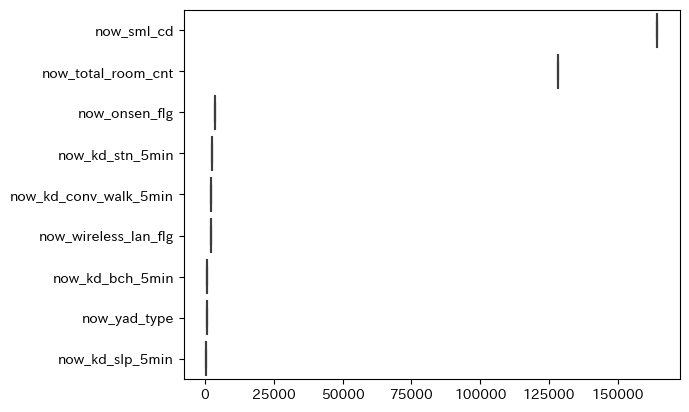

In [65]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

# Testに対する推論

In [128]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

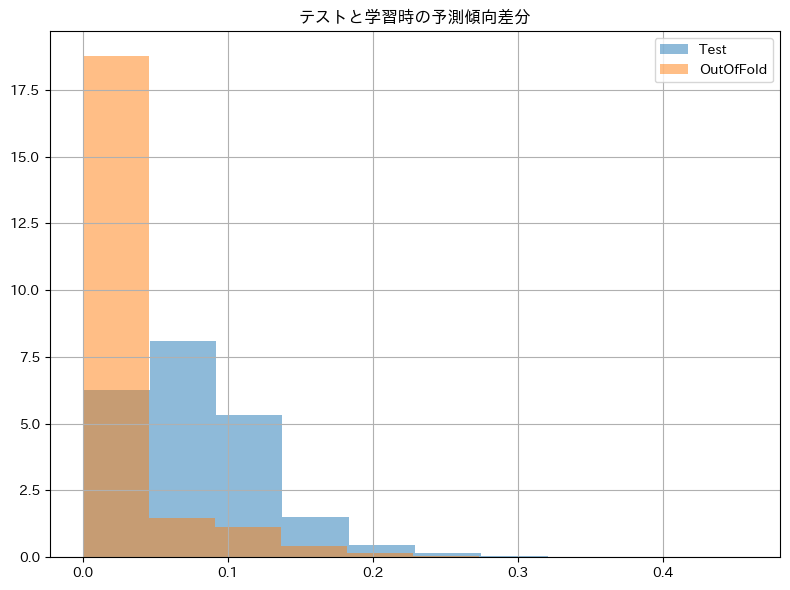

In [129]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [130]:
test["pred"] = pred

In [131]:
# TOP10に並び替え
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [132]:
pred_yad_df.isnull().sum()

predict_0    0
predict_1    0
predict_2    0
predict_3    0
predict_4    0
predict_5    0
predict_6    0
predict_7    0
predict_8    0
predict_9    0
dtype: int64

In [133]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,9830,6766,4422,11930,4948,5466,2986,4128,2680,10965
1,4066,5267,7913,11923,12862,143,8821,8108,6129,6555
2,1774,410,9910,2142,4999,757,9190,2267,7710,10104
3,277,12341,2795,10535,6991,5657,1161,3359,7413,1844
4,5713,6047,9611,12524,13323,11512,101,1268,3064,11494
...,...,...,...,...,...,...,...,...,...,...
174695,7888,1885,11123,1997,8771,6719,5838,6282,11153,11848
174696,1227,13702,8127,3802,9782,2232,6874,9723,4541,2491
174697,12425,10155,6199,8468,2087,11037,12240,11850,2927,12089
174698,3100,6378,2692,2305,5513,6895,2373,6801,11496,8669


In [134]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [135]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)